In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from torch import nn
import os, sys
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Check if the helper_functions.py file exists
vits_project_path = '/content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main'
if os.path.exists(os.path.join(vits_project_path, 'helper_functions.py')):
    print("helper_functions.py found!")
else:
    print("helper_functions.py NOT found. Please check the path.")

# Add the project folder to Python's sys.path
sys.path.append(vits_project_path)

# Import the helper function
from helper_functions import set_seeds



Mounted at /content/drive
helper_functions.py found!


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 158MB/s]


In [5]:
!pip install -q torchinfo
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [20]:

# Set the base path for accessing the dataset from Google Drive
dataset_base_path = '/content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main/custom_dateset'
train_dir = f'{dataset_base_path}/train'
test_dir = f'{dataset_base_path}/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [21]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [22]:
NUM_WORKERS = os.cpu_count()
# Import necessary library for Google Colab

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Define the training data augmentation transforms
  data_augmentation_transforms = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize to target size (ViT usually expects 224x224)
      transforms.RandomRotation(degrees=(-45, 45)),  # Random rotation in range [-30, 30] degrees for more visibility
      transforms.RandomHorizontalFlip(p=1.0),  # X Reflection with probability 1
      transforms.RandomVerticalFlip(p=1.0),  # Y Reflection with probability 1
      transforms.RandomAffine(degrees=0, shear=(-5, 5, -5, 5)),  # X Shear and Y Shear in range [-5, 5]
      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation by up to 10% in both X and Y directions
      transforms.ToTensor(),  # Convert to Tensor

  ])

  # Define the transforms for the test/validation dataset (no augmentations)
  test_transforms = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize to target size
      transforms.RandomRotation(degrees=(-45, 45)),  # Random rotation in range [-30, 30] degrees for more visibility
      transforms.RandomHorizontalFlip(p=1.0),  # X Reflection with probability 1
      transforms.RandomVerticalFlip(p=1.0),  # Y Reflection with probability 1
      transforms.RandomAffine(degrees=0, shear=(-5, 5, -5, 5)),  # X Shear and Y Shear in range [-5, 5]
      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation by up to 10% in both X and Y directions
      transforms.ToTensor(),

  ])

  # Use ImageFolder to create datasets with the transformations
  train_data = datasets.ImageFolder(train_dir, transform=data_augmentation_transforms)
  test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
    # Create data loaders
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)


  return train_dataloader, test_dataloader, class_names

In [23]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


# Getting some sample from the dataset

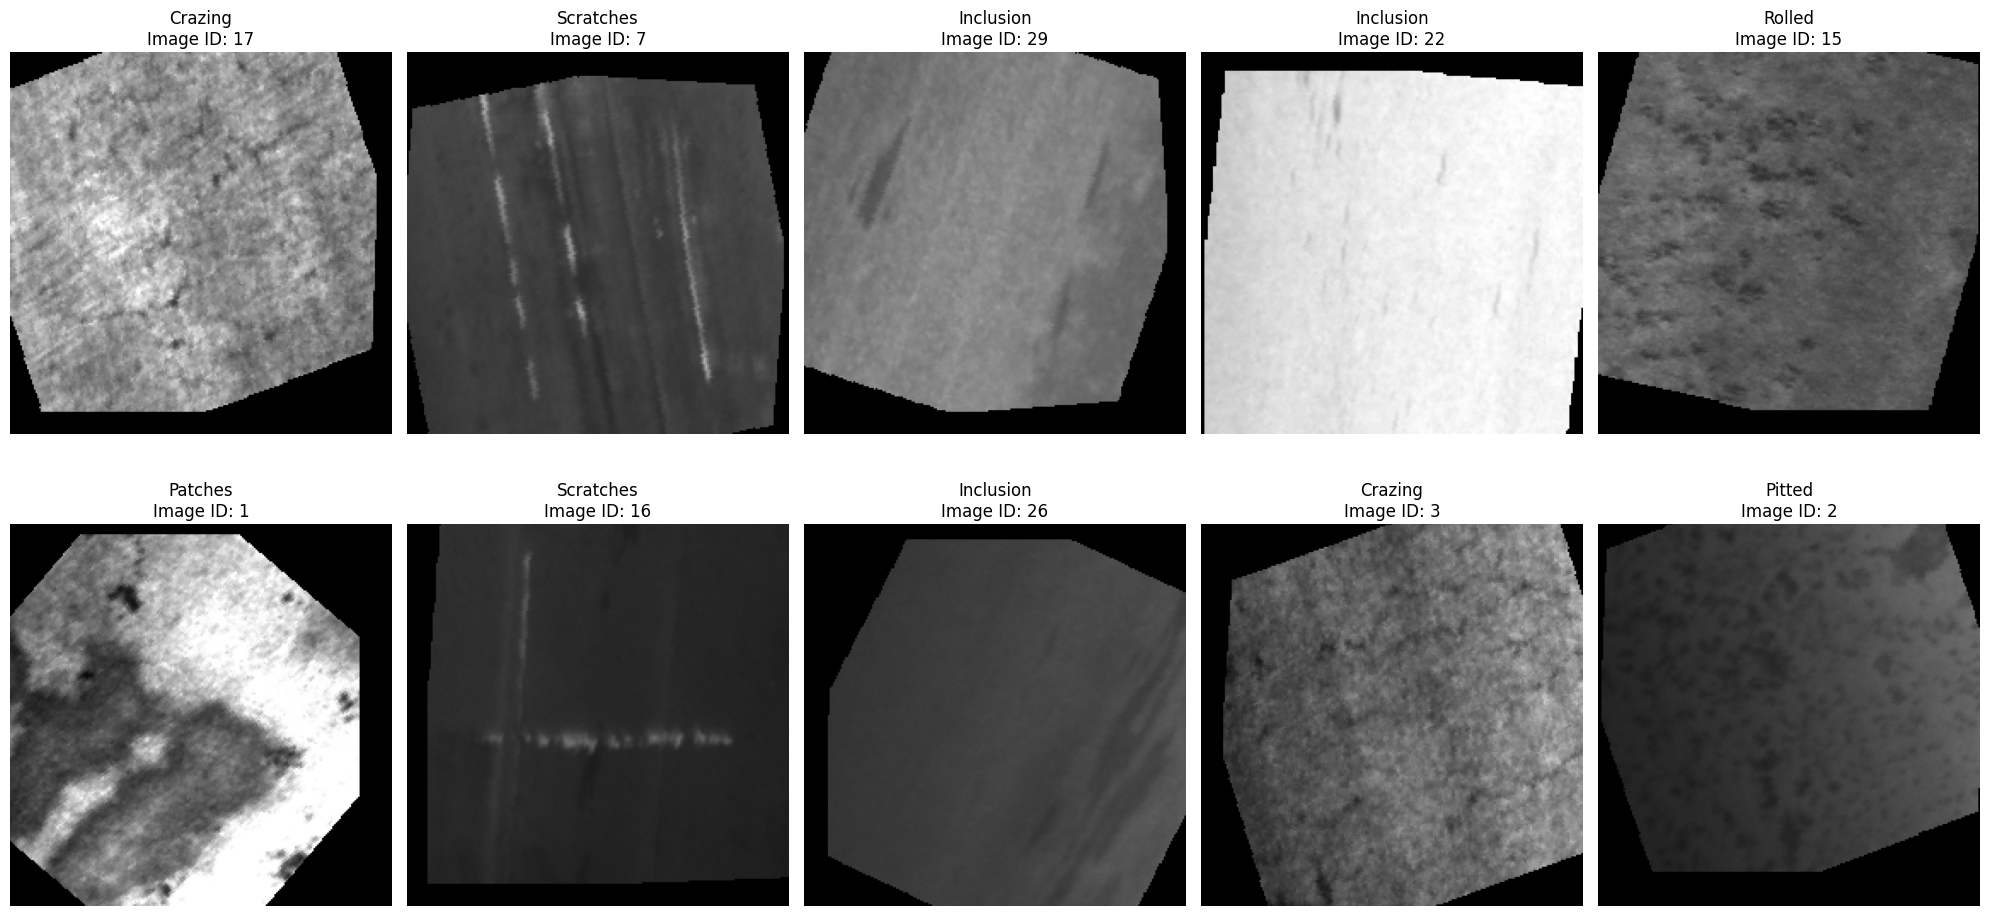


Details of 10 Random Images:
Image ID: 17, Class: Crazing
Image ID: 7, Class: Scratches
Image ID: 29, Class: Inclusion
Image ID: 22, Class: Inclusion
Image ID: 15, Class: Rolled
Image ID: 1, Class: Patches
Image ID: 16, Class: Scratches
Image ID: 26, Class: Inclusion
Image ID: 3, Class: Crazing
Image ID: 2, Class: Pitted


In [24]:
import matplotlib.pyplot as plt
import random

# Assuming 'train_dataloader_pretrained' is already defined
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader_pretrained))

# Display 10 random images from the batch
plt.figure(figsize=(20, 10))

# Select 10 random indices from the batch
random_indices = random.sample(range(len(image_batch)), 10)

for i, idx in enumerate(random_indices):
    image, label = image_batch[idx], label_batch[idx]

    # Rearrange image dimensions for matplotlib (from C x H x W to H x W x C)
    image = image.permute(1, 2, 0)

    # Display the image with title as the class name
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"{class_names[label]}\nImage ID: {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Display image class and filename for each selected image
print("\nDetails of 10 Random Images:")
for idx in random_indices:
    label = label_batch[idx]
    print(f"Image ID: {idx}, Class: {class_names[label]}")


# Showing images after data agumentaion

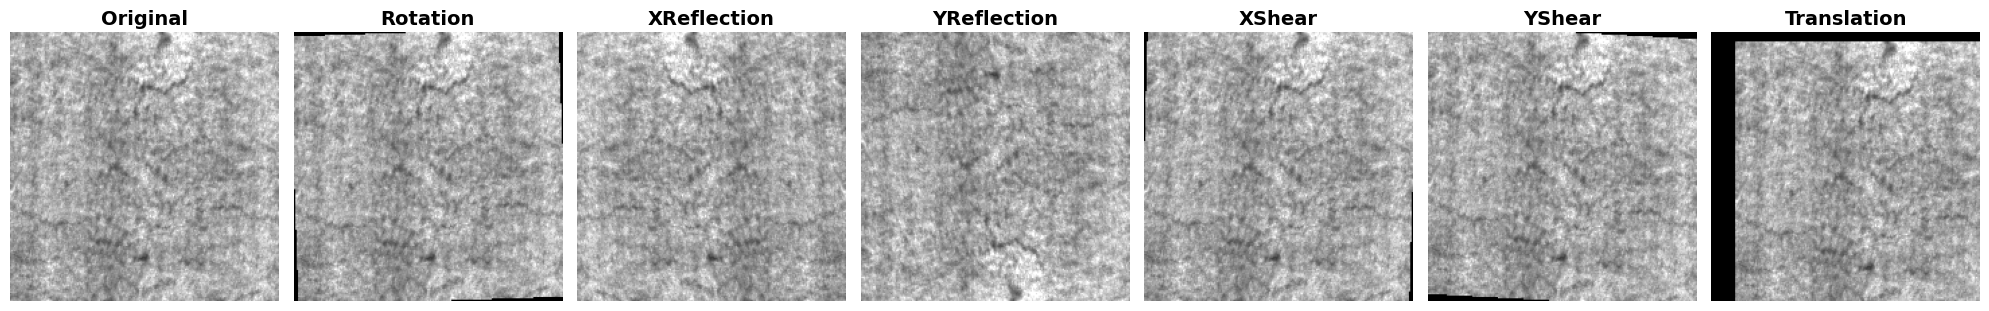

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets
import torch

# Load the training dataset
train_data = datasets.ImageFolder(train_dir)

# Load an example image from the training dataset
original_image, label = train_data[5]  # Get the first image in the training dataset
class_name = train_data.classes[label]

# Convert the original image (PIL) to a Tensor for further operations
to_tensor = transforms.ToTensor()
original_image_tensor = to_tensor(original_image)  # Now it's a tensor

# Define data augmentation transformations including Translation
augmentation_transformations = {
    "Rotation": transforms.Compose([transforms.RandomRotation(degrees=(-30, 30)), transforms.ToTensor()]),
    "XReflection": transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
    "YReflection": transforms.Compose([transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor()]),
    "XShear": transforms.Compose([transforms.RandomAffine(degrees=0, shear=(-5, 5, 0, 0)), transforms.ToTensor()]),
    "YShear": transforms.Compose([transforms.RandomAffine(degrees=0, shear=(0, 0, -5, 5)), transforms.ToTensor()]),
    "Translation": transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ToTensor()])  # Translation by up to 10%
}

# Function to display the original and augmented images with labels
def plot_augmentations(original_image_tensor, augmentation_transformations):
    num_transforms = len(augmentation_transformations)
    fig, axes = plt.subplots(1, num_transforms + 1, figsize=(20, 5))

    # Plot the original image
    axes[0].imshow(original_image_tensor.permute(1, 2, 0).numpy())  # Convert tensor to numpy for visualization
    axes[0].set_title("Original", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Plot transformed images with their respective labels
    for i, (transform_name, transform) in enumerate(augmentation_transformations.items(), start=1):
        augmented_image_tensor = transform(original_image)  # Apply augmentation to original PIL image
        axes[i].imshow(augmented_image_tensor.permute(1, 2, 0).numpy())  # No normalization applied
        axes[i].set_title(transform_name, fontsize=14, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot original and augmented versions
plot_augmentations(original_image_tensor, augmentation_transformations)


# Create optimizer, Loss Function and Training the model

In [26]:
from going_modular.going_modular import engine

# Create optimizer and loss function
'''optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
                             '''

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr= 3e-3,    #1e-4, 3e-3,Base LR from Table 3 for ViT-* ImageNet-1k, in my project,changed due to small dataset
                             betas=(0.9, 0.999),
                             weight_decay=0.01) # Reduced weight decay to avoid over-regularization

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5268 | train_acc: 0.8610 | test_loss: 0.1526 | test_acc: 0.9818
Epoch: 2 | train_loss: 0.1270 | train_acc: 0.9840 | test_loss: 0.0988 | test_acc: 0.9870
Epoch: 3 | train_loss: 0.0952 | train_acc: 0.9896 | test_loss: 0.0689 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0792 | train_acc: 0.9903 | test_loss: 0.0633 | test_acc: 0.9974
Epoch: 5 | train_loss: 0.0705 | train_acc: 0.9924 | test_loss: 0.0608 | test_acc: 0.9974
Epoch: 6 | train_loss: 0.0704 | train_acc: 0.9924 | test_loss: 0.0485 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0654 | train_acc: 0.9903 | test_loss: 0.0529 | test_acc: 0.9974
Epoch: 8 | train_loss: 0.0630 | train_acc: 0.9924 | test_loss: 0.0686 | test_acc: 0.9896
Epoch: 9 | train_loss: 0.0607 | train_acc: 0.9958 | test_loss: 0.0482 | test_acc: 0.9974
Epoch: 10 | train_loss: 0.0618 | train_acc: 0.9889 | test_loss: 0.0546 | test_acc: 1.0000
Epoch: 11 | train_loss: 0.0568 | train_acc: 0.9965 | test_loss: 0.0465 | test_acc: 1.0000
Epoch: 12 | train_l

#  After Training Evaluation


--- Post-training Evaluation ---



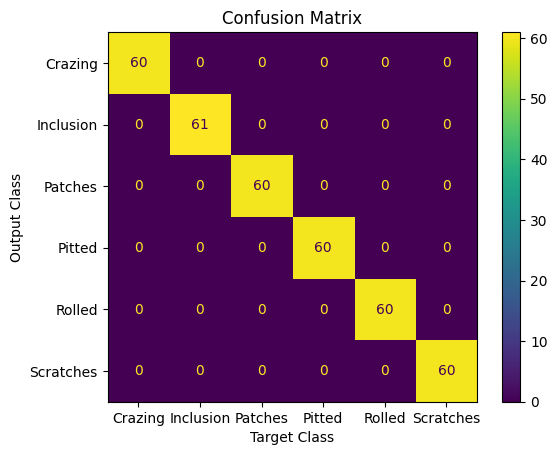

Classification Report:
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        60
   Inclusion       1.00      1.00      1.00        61
     Patches       1.00      1.00      1.00        60
      Pitted       1.00      1.00      1.00        60
      Rolled       1.00      1.00      1.00        60
   Scratches       1.00      1.00      1.00        60

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361



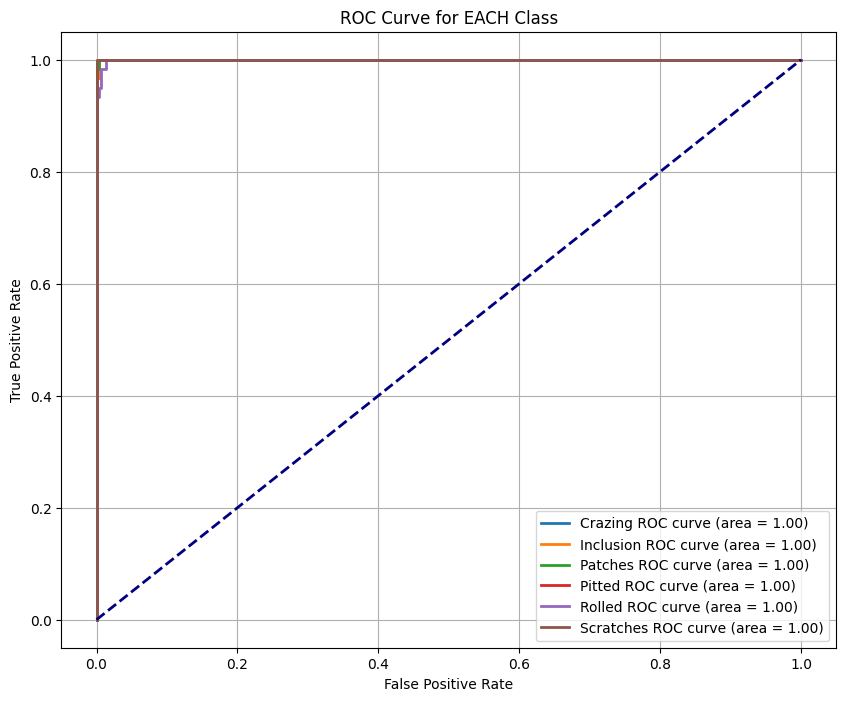

Model Evaluation Metrics:
Accuracy (AC): 100.00%
Sensitivity (SE): 100.00%
Specificity (SP): 100.00%
Error Rate (ER): 0.00%


In [50]:
# After Training Evaluation
print("\n--- Post-training Evaluation ---\n")

# Updated evaluate_model function to accept class_names argument and evaluate the model
def evaluate_model(model, dataloader, class_names, device="cpu"):
    """Evaluates a trained PyTorch model and produces evaluation metrics and graphs.
    Args:
        model (torch.nn.Module): Trained model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader containing test data.
        class_names (list): List of class names.
        device (str, optional): Device to perform evaluation on. Defaults to "cpu".
    Returns:
        None: Displays confusion matrix, classification report, ROC curve, and accuracy/loss graphs.
    """
    import numpy as np
    from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import torch
    from sklearn.preprocessing import label_binarize

    model.eval()
    y_true = []
    y_pred = []
    y_score = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_score.extend(outputs.cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.xlabel("Target Class")
    plt.ylabel("Output Class")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calculate AUC, Accuracy, Sensitivity, Specificity, and Error Rate
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    accuracy = np.mean(y_true_np == y_pred_np)

    # One-vs-Rest ROC Curve for Multiclass Classification
    y_true_bin = label_binarize(y_true_np, classes=np.unique(y_true_np))
    y_score_np = np.array(y_score)
    n_classes = y_true_bin.shape[1]

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score_np[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for EACH Class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Sensitivity and Specificity Calculation
    sensitivity = np.sum((y_true_np == 1) & (y_pred_np == 1)) / np.sum(y_true_np == 1)
    specificity = np.sum((y_true_np == 0) & (y_pred_np == 0)) / np.sum(y_true_np == 0)
    error_rate = 1 - accuracy

    print(f"Model Evaluation Metrics:")
    print(f"Accuracy (AC): {accuracy * 100:.2f}%")
    print(f"Sensitivity (SE): {sensitivity * 100:.2f}%")
    print(f"Specificity (SP): {specificity * 100:.2f}%")
    print(f"Error Rate (ER): {error_rate * 100:.2f}%")

# Evaluate the model after training using the updated function
evaluate_model(model=pretrained_vit,
               dataloader=test_dataloader_pretrained,
               class_names=class_names,
               device=device)


# Plotting Loss and Accuracy Curves

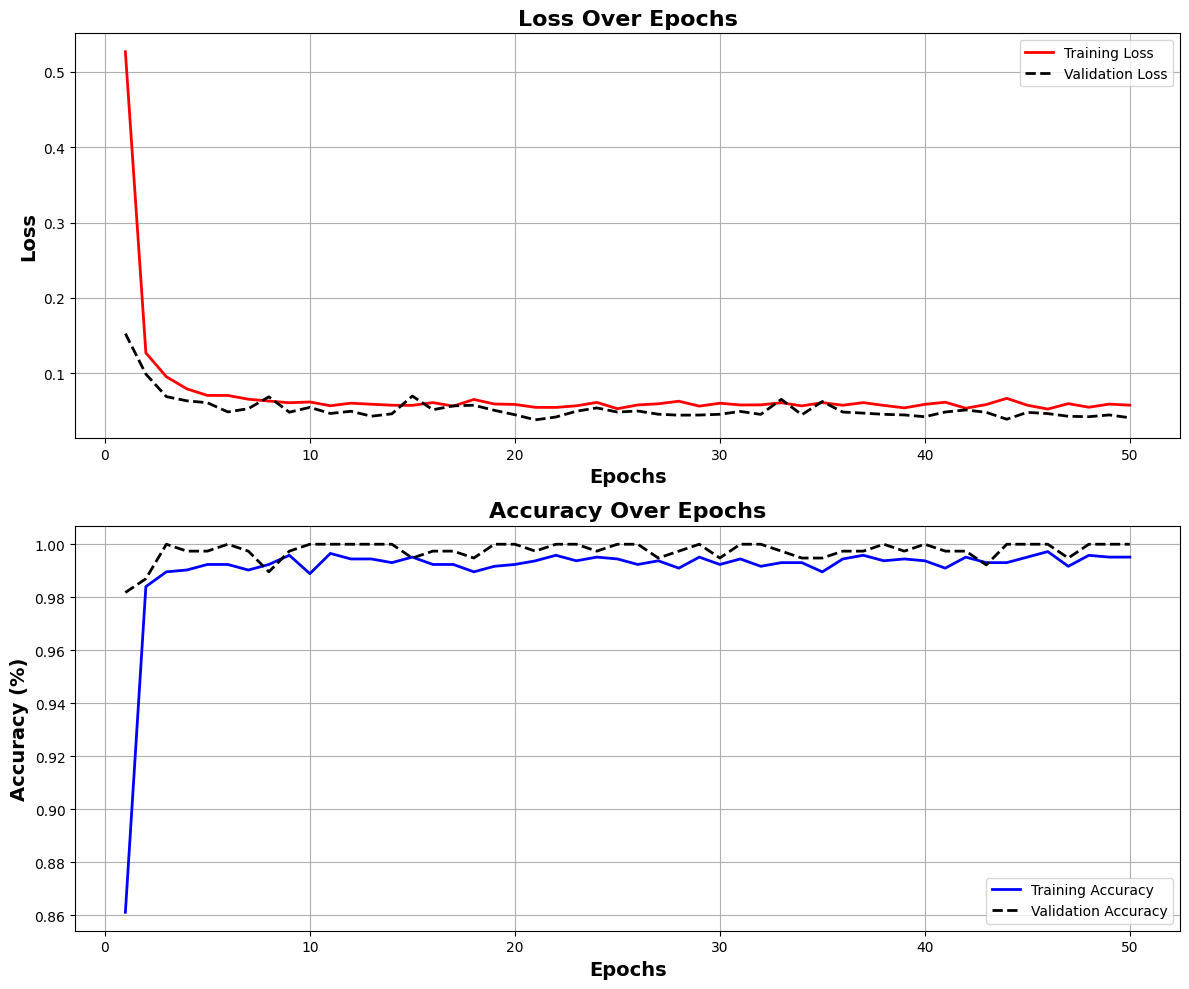

In [47]:
# Plotting Loss and Accuracy Curves
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots training and validation loss and accuracy curves.
    Args:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - train_accuracies: List of training accuracies.
    - val_accuracies: List of validation accuracies.
    """
    epochs = range(1, len(train_losses) + 1)

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # Plot Loss
    axs[0].plot(epochs, train_losses, label='Training Loss', color='red', linestyle='-', linewidth=2)
    axs[0].plot(epochs, val_losses, label='Validation Loss', color='black', linestyle='--', linewidth=2)
    axs[0].set_title('Loss Over Epochs', fontsize=16, fontweight='bold')
    axs[0].set_xlabel('Epochs', fontsize=14, fontweight='bold')
    axs[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(epochs, train_accuracies, label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
    axs[1].plot(epochs, val_accuracies, label='Validation Accuracy', color='black', linestyle='--', linewidth=2)
    axs[1].set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold')
    axs[1].set_xlabel('Epochs', fontsize=14, fontweight='bold')
    axs[1].set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Assuming pretrained_vit_results has loss and accuracy data
plot_loss_accuracy(pretrained_vit_results['train_loss'], pretrained_vit_results['test_loss'],
                   pretrained_vit_results['train_acc'], pretrained_vit_results['test_acc'])


# Confusion_matrix, and Classification_report of the model after Training

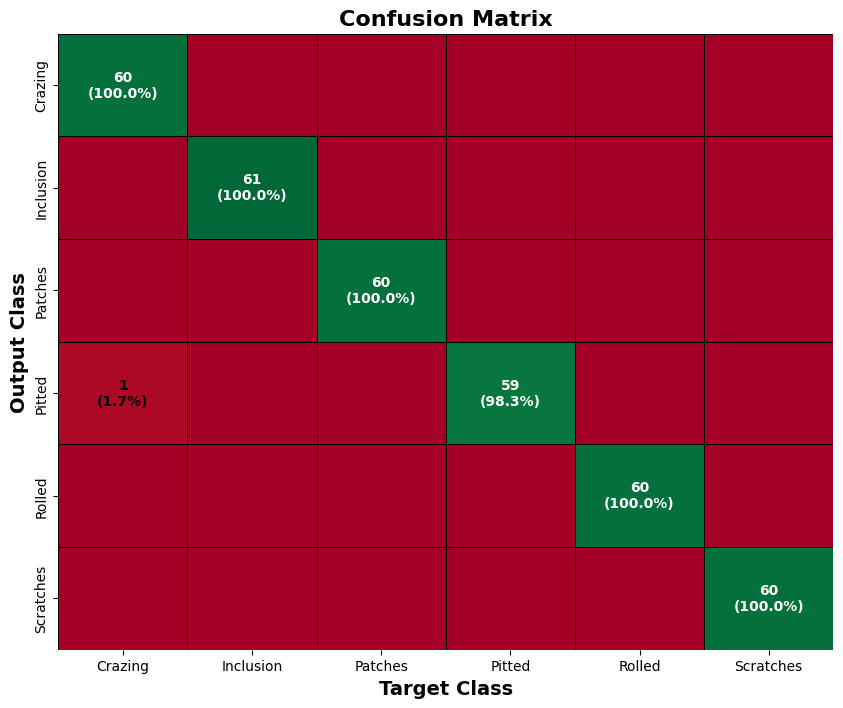

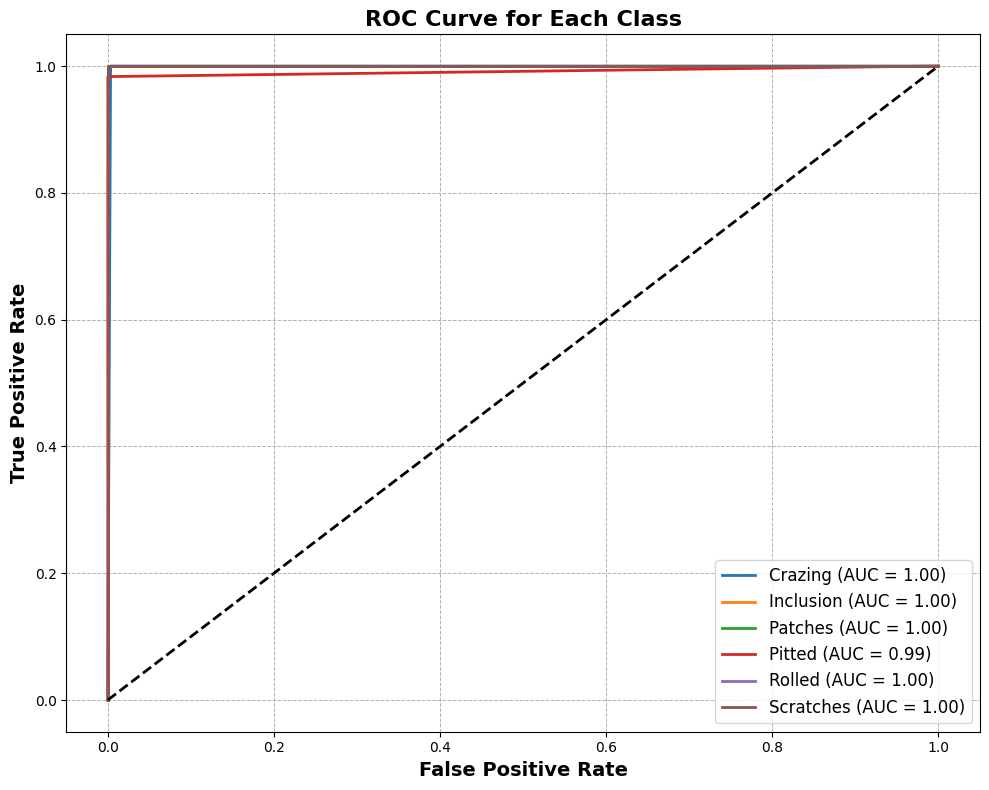

Confusion Matrix:
 [[60  0  0  0  0  0]
 [ 0 61  0  0  0  0]
 [ 0  0 60  0  0  0]
 [ 1  0  0 59  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 60]]

Classification Report:
               precision    recall  f1-score   support

     Crazing       0.98      1.00      0.99        60
   Inclusion       1.00      1.00      1.00        61
     Patches       1.00      1.00      1.00        60
      Pitted       1.00      0.98      0.99        60
      Rolled       1.00      1.00      1.00        60
   Scratches       1.00      1.00      1.00        60

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361


Evaluation Metrics:
Accuracy (AC %): 99.72%
Sensitivity (SE %): 99.72%
Specificity (SP %): 99.73%
Error Rate (ER %): 0.28%
AUC (Average): 1.00


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, accuracy_score,
                             precision_score, recall_score)
import seaborn as sns

def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Normalize the Confusion Matrix for Percentages
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Plot Confusion Matrix with Counts and Percentages
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(conf_matrix, annot=False, cmap='RdYlGn', linewidths=0.5, linecolor='black', cbar=False,
                     xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Target Class', fontsize=14, fontweight='bold')
    plt.ylabel('Output Class', fontsize=14, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

    # Adding counts and percentages to each cell
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            count = conf_matrix[i, j]
            percentage = conf_matrix_percentage[i, j]
            if count > 0:
                ax.text(j + 0.5, i + 0.5, f"{count}\n({percentage:.1f}%)",
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=10,
                        fontweight='bold',
                        color='black' if percentage < 50 else 'white')

    plt.show()

    # Compute Overall Metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100  # Accuracy as a percentage
    sensitivity = recall_score(all_labels, all_preds, average='macro') * 100  # Recall as a percentage (Sensitivity)
    precision = precision_score(all_labels, all_preds, average='macro') * 100  # Precision as Specificity approximation
    error_rate = 100 - accuracy  # Error rate as a percentage

    # AUC for Each Class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    all_labels_one_hot = np.eye(len(class_names))[all_labels]

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], (np.array(all_preds) == i).astype(int))
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('ROC Curve for Each Class', fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.legend(loc='lower right', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print Confusion Matrix Details
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Print Calculated Metrics
    print(f"\nEvaluation Metrics:")
    print(f"Accuracy (AC %): {accuracy:.2f}%")
    print(f"Sensitivity (SE %): {sensitivity:.2f}%")
    print(f"Specificity (SP %): {precision:.2f}%")  # Using Precision as an estimate for Specificity
    print(f"Error Rate (ER %): {error_rate:.2f}%")

    # Printing Overall AUC Score
    mean_auc = np.mean(list(roc_auc.values()))
    print(f"AUC (Average): {mean_auc:.2f}")


# Call the evaluation function
evaluate_model(pretrained_vit, test_dataloader_pretrained, class_names, device)


# Let's make Prediction:

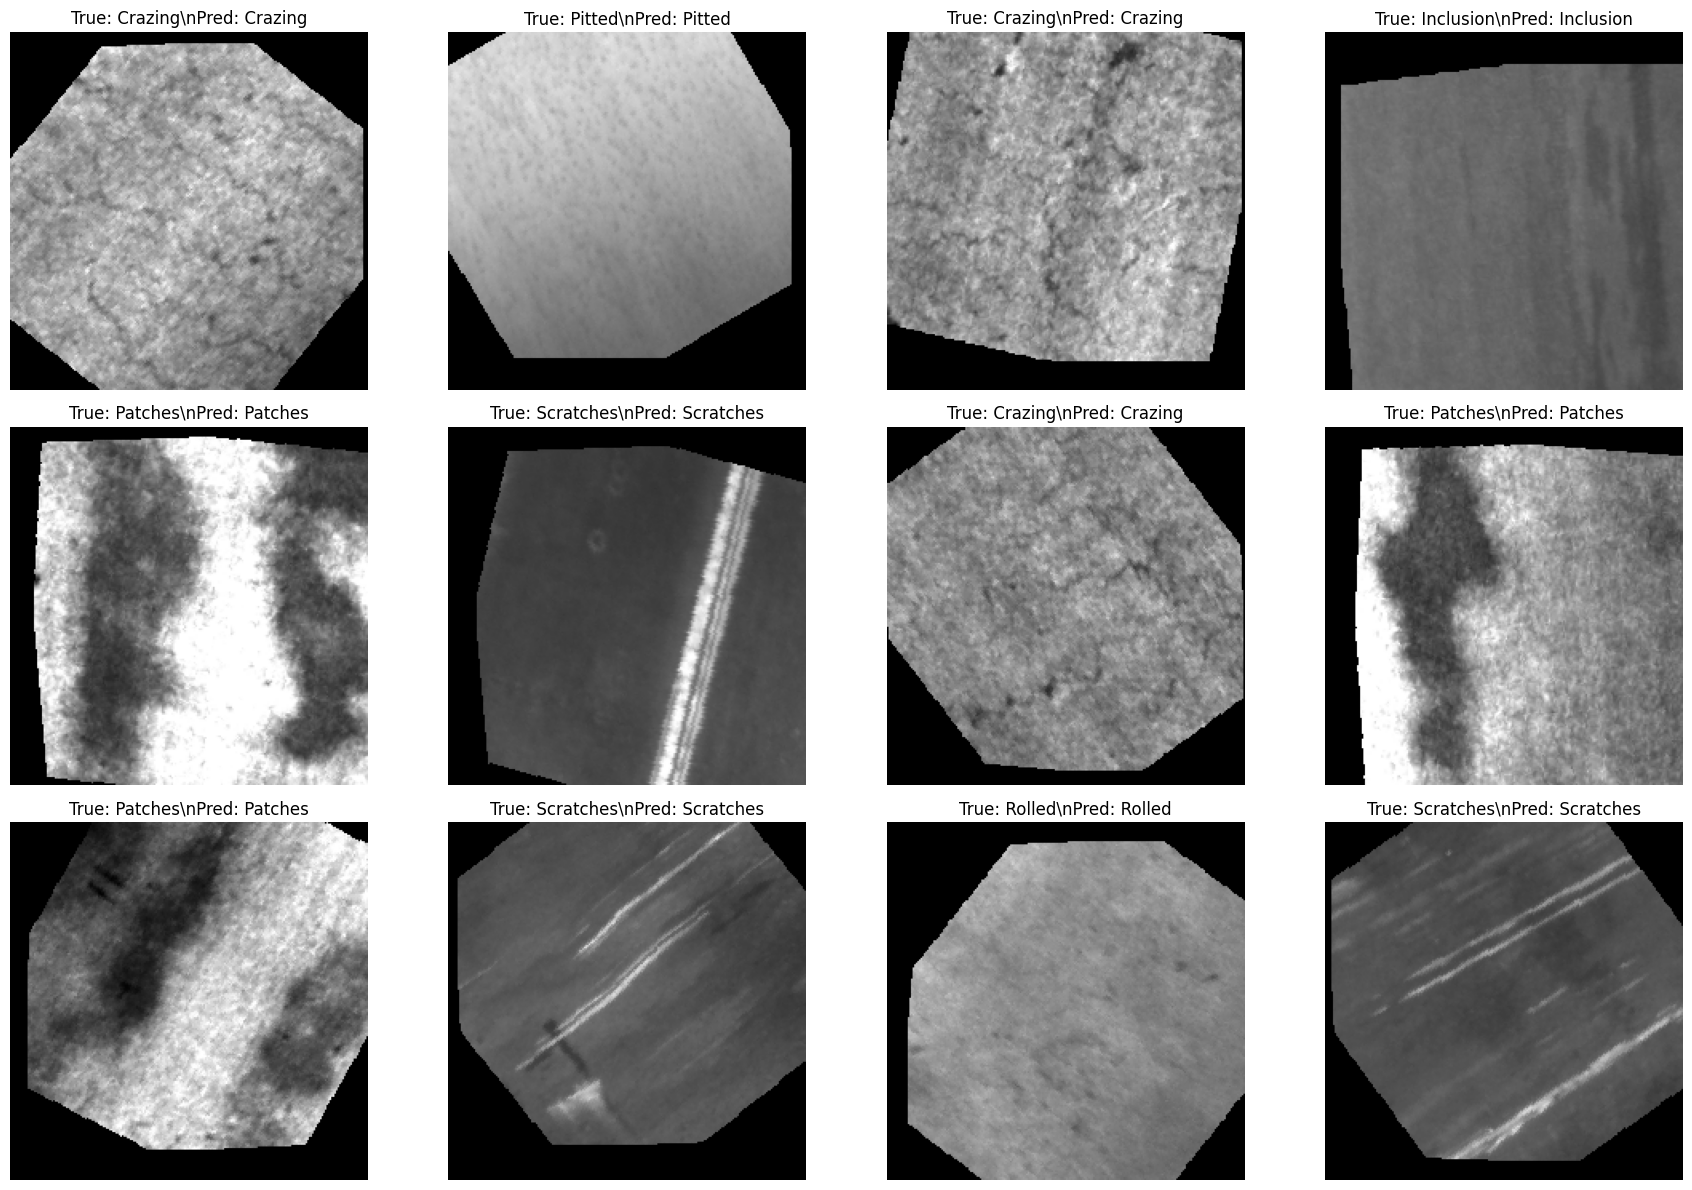

In [52]:
import torchvision.models as models

def show_predictions(model, dataloader, class_names, device):
    model.eval()
    fig = plt.figure(figsize=(18, 12))
    shown_images = []

    with torch.no_grad():
        # Get all data in one pass to randomly select images later
        all_inputs, all_labels = [], []
        for inputs, labels in dataloader:
            all_inputs.append(inputs)
            all_labels.append(labels)

        all_inputs = torch.cat(all_inputs)
        all_labels = torch.cat(all_labels)
        indices = list(range(len(all_inputs)))
        random.shuffle(indices)

        images_shown = 0
        for idx in indices:
            if images_shown == 12:
                break

            input_img = all_inputs[idx].unsqueeze(0).to(device)
            label = all_labels[idx].to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            image = input_img[0].cpu().permute(1, 2, 0).numpy()
            true_label = class_names[label]
            predicted_label = class_names[pred]

            ax = fig.add_subplot(3, 4, images_shown + 1)
            ax.imshow(image)
            ax.set_title(f'True: {true_label}\\nPred: {predicted_label}')
            ax.axis('off')
            images_shown += 1

    plt.tight_layout()
    plt.show()

# Show predictions
show_predictions(pretrained_vit, test_dataloader_pretrained, class_names, device)


Saving the model:

In [32]:

# Set the directory in Google Drive where you want to save the model
save_model_dir = '/content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main/saved_models'
if not os.path.exists(save_model_dir):
    os.makedirs(save_model_dir)

# Save the trained model after training is done
model_save_path = os.path.join(save_model_dir, 'trained_pretrained_vit1.pth')
torch.save(pretrained_vit.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main/saved_models/trained_pretrained_vit1.pth


In [53]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transformations for the original test dataset (no augmentation)
original_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of the model
    transforms.ToTensor(),          # Convert to tensor
])

# Create a DataLoader for the original, non-augmented test dataset
original_test_dataset = datasets.ImageFolder(test_dir, transform=original_test_transform)
original_test_dataloader = DataLoader(original_test_dataset, batch_size=64, shuffle=False)


# Let's make Prediction on the original Dataset 

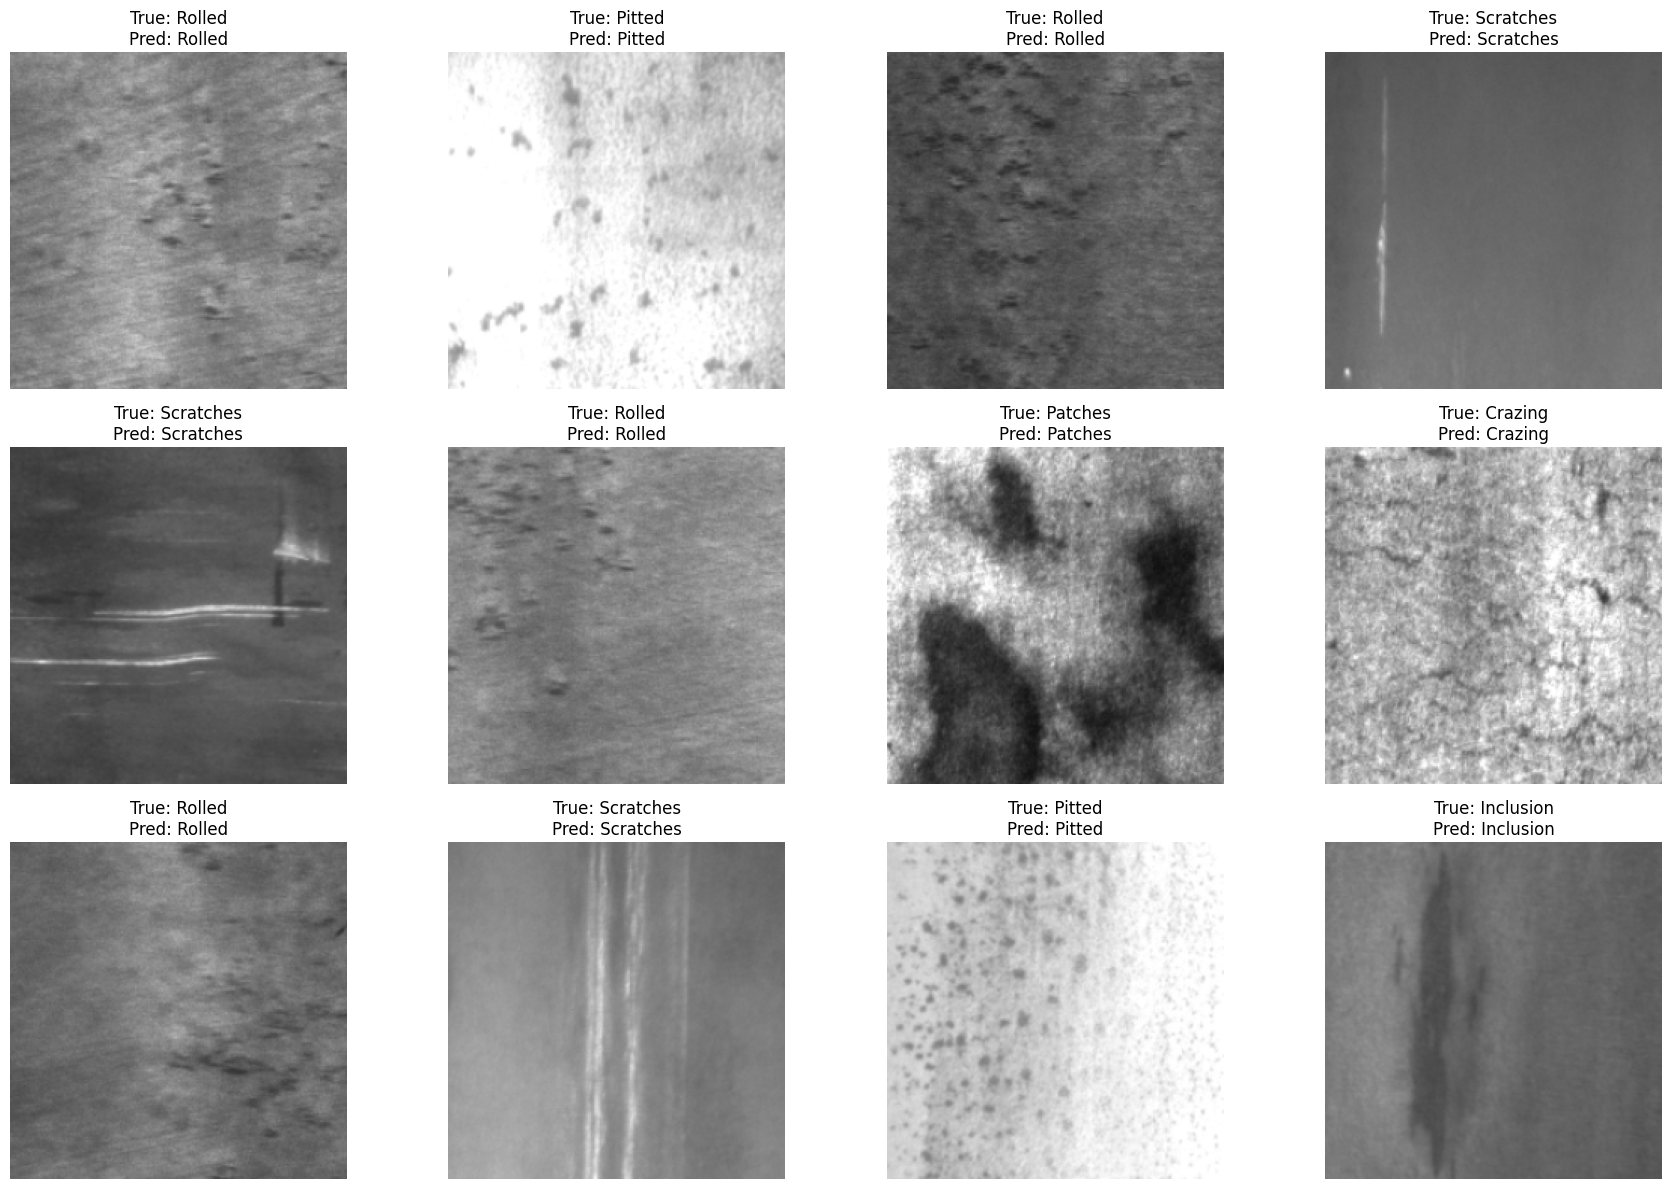

In [56]:
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import random

# Function to show predictions on the original test dataset
def show_predictions(model, dataloader, class_names, device):
    model.eval()
    fig = plt.figure(figsize=(18, 12))
    shown_images = []

    with torch.no_grad():
        # Get all data in one pass to randomly select images later
        all_inputs, all_labels = [], []
        for inputs, labels in dataloader:
            all_inputs.append(inputs)
            all_labels.append(labels)

        all_inputs = torch.cat(all_inputs)
        all_labels = torch.cat(all_labels)
        indices = list(range(len(all_inputs)))
        random.shuffle(indices)

        images_shown = 0
        for idx in indices:
            if images_shown == 12:
                break

            input_img = all_inputs[idx].unsqueeze(0).to(device)
            label = all_labels[idx].to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            image = input_img[0].cpu().permute(1, 2, 0).numpy()
            true_label = class_names[label]
            predicted_label = class_names[pred]

            ax = fig.add_subplot(3, 4, images_shown + 1)
            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {predicted_label}')
            ax.axis('off')
            images_shown += 1

    plt.tight_layout()
    plt.show()

# Show predictions on the original dataset (before augmentation)
show_predictions(pretrained_vit, original_test_dataloader, class_names, device)



--- Post-training Evaluation ---


--- Model Evaluation Metrics ---
Overall AUC: 1.00
Accuracy (AC %): 99.72%
Sensitivity (SE %): 99.73%
Specificity (SP %): 99.73%
Error Rate (ER %): 0.28%

--- Class-wise Metrics ---

Class: Crazing
  AUC: 1.00
  Sensitivity (SE %): 100.00%
  Specificity (SP %): 100.00%
  Accuracy (AC %): 100.00%

Class: Inclusion
  AUC: 1.00
  Sensitivity (SE %): 98.36%
  Specificity (SP %): 100.00%
  Accuracy (AC %): 98.36%

Class: Patches
  AUC: 1.00
  Sensitivity (SE %): 100.00%
  Specificity (SP %): 100.00%
  Accuracy (AC %): 100.00%

Class: Pitted
  AUC: 1.00
  Sensitivity (SE %): 100.00%
  Specificity (SP %): 98.36%
  Accuracy (AC %): 100.00%

Class: Rolled
  AUC: 1.00
  Sensitivity (SE %): 100.00%
  Specificity (SP %): 100.00%
  Accuracy (AC %): 100.00%

Class: Scratches
  AUC: 1.00
  Sensitivity (SE %): 100.00%
  Specificity (SP %): 100.00%
  Accuracy (AC %): 100.00%


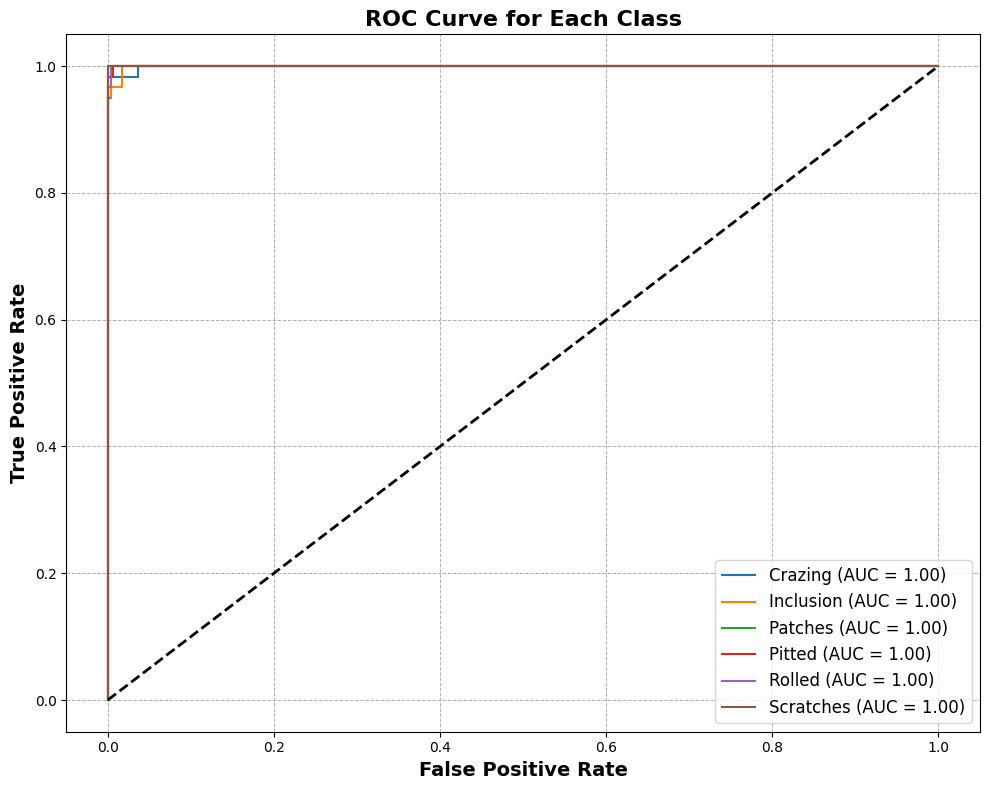

In [57]:
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, accuracy_score,
                             precision_score, recall_score)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# After Training Evaluation
print("\n--- Post-training Evaluation ---\n")

def evaluate_model_metrics(model, dataloader, class_names, device="cpu"):
    """Evaluates the model's AUC, Accuracy, Sensitivity, Specificity, Error Rate per class and overall."""
    model.eval()
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    # Convert to NumPy arrays for further evaluation
    all_labels_np = np.array(all_labels)
    all_preds_np = np.array(all_preds)
    all_scores_np = np.array(all_scores)

    # Compute Overall Metrics
    accuracy = accuracy_score(all_labels_np, all_preds_np) * 100
    sensitivity = recall_score(all_labels_np, all_preds_np, average='macro') * 100
    specificity = precision_score(all_labels_np, all_preds_np, average='macro') * 100
    error_rate = 100 - accuracy

    # AUC for Each Class
    y_true_bin = label_binarize(all_labels_np, classes=np.unique(all_labels_np))
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_scores_np[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Mean AUC
    mean_auc = np.mean(list(roc_auc.values()))

    # Print Metrics
    print("\n--- Model Evaluation Metrics ---")
    print(f"Overall AUC: {mean_auc:.2f}")
    print(f"Accuracy (AC %): {accuracy:.2f}%")
    print(f"Sensitivity (SE %): {sensitivity:.2f}%")
    print(f"Specificity (SP %): {specificity:.2f}%")
    print(f"Error Rate (ER %): {error_rate:.2f}%")

    # Metrics for Each Class
    print("\n--- Class-wise Metrics ---")
    for i, class_name in enumerate(class_names):
        class_auc = roc_auc[i]
        class_sensitivity = recall_score(all_labels_np, all_preds_np, labels=[i], average='macro') * 100
        class_specificity = precision_score(all_labels_np, all_preds_np, labels=[i], average='macro') * 100
        class_accuracy = (confusion_matrix(all_labels_np, all_preds_np)[i][i] / np.sum(confusion_matrix(all_labels_np, all_preds_np)[i])) * 100

        print(f"\nClass: {class_name}")
        print(f"  AUC: {class_auc:.2f}")
        print(f"  Sensitivity (SE %): {class_sensitivity:.2f}%")
        print(f"  Specificity (SP %): {class_specificity:.2f}%")
        print(f"  Accuracy (AC %): {class_accuracy:.2f}%")

    # Plot ROC Curve for Each Class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('ROC Curve for Each Class', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()

# Call the evaluation function after training
evaluate_model_metrics(model=pretrained_vit, dataloader=test_dataloader_pretrained, class_names=class_names, device=device)
